# 03 - Temperature Parameter Comparison

This notebook compares different temperature values for RAG applications:
- Temperature: 0.0, 0.2, 0.5, 0.7, 1.2, 1.5, 2.0

We'll evaluate: accuracy, creativity, diversity, consistency, and response quality.

In [1]:
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import re

load_dotenv()
client = OpenAI()

# Test queries about Gemini
TEST_QUERIES = [
    "What are the key capabilities of Gemini models?",
    "How does Gemini compare to other multimodal models?", 
    "What are the different versions of Gemini?",
    "What training data was used for Gemini?",
    "What are the safety measures in Gemini models?",
    "How does Gemini perform on benchmarks?",
    "What is the architecture of Gemini?",
    "What are the limitations of Gemini?"
]

# Temperature values to test
TEMPERATURES = [0.0, 0.2, 0.5, 0.7, 1.2, 1.5, 2.0]

print(f"Testing {len(TEMPERATURES)} temperature values")
print(f"Using {len(TEST_QUERIES)} test queries")

Testing 7 temperature values
Using 8 test queries


In [2]:
# Enhanced LLM Judge for Temperature-Specific Evaluation
def llm_judge_temperature(query, answer, context, judge_model="gpt-4o-mini"):
    judge_prompt = f"""
You are an expert evaluator assessing RAG responses with focus on temperature effects.

CONTEXT:
{context[:2000]}...

QUESTION: {query}

ANSWER: {answer}

Evaluate on these 6 criteria using this scale:
- Poor (1): Severely lacking
- Below Average (2): Partially adequate
- Average (3): Meets basic requirements
- Good (4): High quality
- Excellent (5): Outstanding

CRITERIA:
1. Accuracy: Factual correctness based on context
2. Completeness: Addresses all parts of the question
3. Clarity: Well-structured and understandable
4. Creativity: Novel insights or creative explanations
5. Diversity: Varied vocabulary and expression
6. Consistency: Logical flow and coherence

Respond in this exact format:
Accuracy: [Rating]
Completeness: [Rating]
Clarity: [Rating]
Creativity: [Rating]
Diversity: [Rating]
Consistency: [Rating]
Overall: [Rating]
Reasoning: [Brief explanation]
"""
    
    try:
        response = client.chat.completions.create(
            model=judge_model,
            messages=[{"role": "user", "content": judge_prompt}],
            temperature=0.1,
            max_tokens=400
        )
        
        evaluation = response.choices[0].message.content
        lines = evaluation.strip().split('\n')
        result = {}
        
        for line in lines:
            if ':' in line:
                key, value = line.split(':', 1)
                result[key.strip().lower()] = value.strip()
        
        return {
            'accuracy': result.get('accuracy', 'N/A'),
            'completeness': result.get('completeness', 'N/A'),
            'clarity': result.get('clarity', 'N/A'),
            'creativity': result.get('creativity', 'N/A'),
            'diversity': result.get('diversity', 'N/A'),
            'consistency': result.get('consistency', 'N/A'),
            'overall': result.get('overall', 'N/A'),
            'reasoning': result.get('reasoning', 'N/A')
        }
        
    except Exception as e:
        return {
            'accuracy': 'Error',
            'completeness': 'Error',
            'clarity': 'Error',
            'creativity': 'Error',
            'diversity': 'Error',
            'consistency': 'Error',
            'overall': 'Error',
            'reasoning': f'Evaluation failed: {str(e)}'
        }

print("Enhanced LLM Judge function ready")

Enhanced LLM Judge function ready


In [7]:
# Load RAG embeddings and setup
with open(r'C:\Users\Admin\Desktop\para-expe\data\rag_embeddings.pkl', 'rb') as f:
    rag_data = pickle.load(f)

chunks = rag_data['chunks']
embedding_results = rag_data['embedding_results']
embeddings = embedding_results['text-embedding-3-small']['embeddings']

print(f"Using embeddings from text-embedding-3-small model")

# RAG retrieval function
def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

def retrieve_chunks(query, chunks, embeddings, k=3):
    query_embedding = get_embedding(query)
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:k]
    
    retrieved_chunks = []
    for idx in top_indices:
        retrieved_chunks.append({
            'chunk': chunks[idx],
            'similarity': similarities[idx]
        })
    
    return retrieved_chunks

Using embeddings from text-embedding-3-small model


In [8]:
# Temperature RAG Experiment Function
def run_temperature_rag_experiment(query, temp):
    start = time.time()
    
    # Retrieve relevant chunks
    retrieved = retrieve_chunks(query, chunks, embeddings, k=3)
    context = "\n\n".join([item['chunk']['text'] for item in retrieved])
    
    # Generate response with context
    prompt = f"""
Use the context below to answer the question. Be accurate and cite specific information from the context.

Context:
{context}

Question: {query}

Answer:"""
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=temp,
        max_tokens=200
    )
    
    latency = time.time() - start
    answer = response.choices[0].message.content
    
    # Get enhanced LLM judge evaluation
    evaluation = llm_judge_temperature(query, answer, context)
    
    # Calculate additional metrics
    word_count = len(answer.split())
    unique_words = len(set(answer.lower().split()))
    lexical_diversity = unique_words / word_count if word_count > 0 else 0
    
    return {
        "query": query,
        "temperature": temp,
        "answer": answer,
        "context_length": len(context),
        "latency": round(latency, 2),
        "tokens": response.usage.total_tokens,
        "word_count": word_count,
        "unique_words": unique_words,
        "lexical_diversity": round(lexical_diversity, 3),
        "accuracy": evaluation['accuracy'],
        "completeness": evaluation['completeness'],
        "clarity": evaluation['clarity'],
        "creativity": evaluation['creativity'],
        "diversity": evaluation['diversity'],
        "consistency": evaluation['consistency'],
        "overall_rating": evaluation['overall'],
        "reasoning": evaluation['reasoning']
    }

print("Temperature RAG experiment function ready")

Temperature RAG experiment function ready


In [9]:
# Run Temperature RAG Experiments
print("Running Temperature RAG experiments...")
results = []

for query in TEST_QUERIES:
    for temp in TEMPERATURES:
        print(f"Testing query: '{query[:50]}...' at temperature {temp}")
        result = run_temperature_rag_experiment(query, temp)
        results.append(result)
        time.sleep(1)  # Rate limiting

df = pd.DataFrame(results)
print(f"\nCompleted {len(results)} Temperature RAG experiments")
print(f"Total combinations: {len(TEST_QUERIES)} queries × {len(TEMPERATURES)} temperatures = {len(TEST_QUERIES) * len(TEMPERATURES)}")

Running Temperature RAG experiments...
Testing query: 'What are the key capabilities of Gemini models?...' at temperature 0.0
Testing query: 'What are the key capabilities of Gemini models?...' at temperature 0.2
Testing query: 'What are the key capabilities of Gemini models?...' at temperature 0.5
Testing query: 'What are the key capabilities of Gemini models?...' at temperature 0.7
Testing query: 'What are the key capabilities of Gemini models?...' at temperature 1.2
Testing query: 'What are the key capabilities of Gemini models?...' at temperature 1.5
Testing query: 'What are the key capabilities of Gemini models?...' at temperature 2.0
Testing query: 'How does Gemini compare to other multimodal models...' at temperature 0.0
Testing query: 'How does Gemini compare to other multimodal models...' at temperature 0.2
Testing query: 'How does Gemini compare to other multimodal models...' at temperature 0.5
Testing query: 'How does Gemini compare to other multimodal models...' at temperat

In [10]:
# Display results summary
df.head()

,query,temperature,answer,context_length,latency,tokens,word_count,unique_words,lexical_diversity,accuracy,completeness,clarity,creativity,diversity,consistency,overall_rating,reasoning
0,What are the key capabilities of Gemini models?,0.0,The key capabilities of Gemini models include:...,10375,6.10,2528,142,107,0.754,5,5,5,3,4,5,5,The response accurately captures the key capab...
1,What are the key capabilities of Gemini models?,0.2,The key capabilities of Gemini models include:...,10375,7.22,2528,137,109,0.796,5,5,5,3,4,5,5,The response accurately captures the key capab...
2,What are the key capabilities of Gemini models?,0.5,The Gemini models exhibit several key capabili...,10375,6.70,2528,145,111,0.766,5,4,5,3,4,5,4,The response accurately reflects the capabilit...
3,What are the key capabilities of Gemini models?,0.7,The key capabilities of Gemini models include:...,10375,5.82,2528,141,108,0.766,5,5,5,4,4,5,5,The response accurately captures the key capab...
4,What are the key capabilities of Gemini models?,1.2,"The key capabilities of Gemini models, particu...",10375,5.67,2528,140,106,0.757,5,4,5,3,4,5,4,The response accurately reflects the key capab...


In [11]:
# Save results
df.to_csv(r'C:\Users\Admin\Desktop\para-expe\data\temperature_rag_results.csv', index=False)
print("Results saved to temperature_rag_results.csv")

# Save detailed results with pickle
with open(r'C:\Users\Admin\Desktop\para-expe\data\temperature_rag_detailed.pkl', 'wb') as f:
    pickle.dump({
        'results': results,
        'test_queries': TEST_QUERIES,
        'temperatures': TEMPERATURES,
        'chunks': chunks,
        'embeddings': embeddings
    }, f)
print("Detailed results saved to temperature_rag_detailed.pkl")

Results saved to temperature_rag_results.csv
Detailed results saved to temperature_rag_detailed.pkl


In [16]:
# Load the saved results
df = pd.read_csv(r'C:\Users\Admin\Desktop\para-expe\data\temperature_rag_results.csv')
print(f"Loaded {len(df)} results")
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Loaded 56 results

Columns: ['query', 'temperature', 'answer', 'context_length', 'latency', 'tokens', 'word_count', 'unique_words', 'lexical_diversity', 'accuracy', 'completeness', 'clarity', 'creativity', 'diversity', 'consistency', 'overall_rating', 'reasoning']

First few rows:


,query,temperature,answer,context_length,latency,tokens,word_count,unique_words,lexical_diversity,accuracy,completeness,clarity,creativity,diversity,consistency,overall_rating,reasoning
0,What are the key capabilities of Gemini models?,0.0,The key capabilities of Gemini models include:...,10375,6.10,2528,142,107,0.754,5,5,5,3,4,5,5.0,The response accurately captures the key capab...
1,What are the key capabilities of Gemini models?,0.2,The key capabilities of Gemini models include:...,10375,7.22,2528,137,109,0.796,5,5,5,3,4,5,5.0,The response accurately captures the key capab...
2,What are the key capabilities of Gemini models?,0.5,The Gemini models exhibit several key capabili...,10375,6.70,2528,145,111,0.766,5,4,5,3,4,5,4.0,The response accurately reflects the capabilit...
3,What are the key capabilities of Gemini models?,0.7,The key capabilities of Gemini models include:...,10375,5.82,2528,141,108,0.766,5,5,5,4,4,5,5.0,The response accurately captures the key capab...
4,What are the key capabilities of Gemini models?,1.2,"The key capabilities of Gemini models, particu...",10375,5.67,2528,140,106,0.757,5,4,5,3,4,5,4.0,The response accurately reflects the key capab...


In [17]:
# Statistical Summary by Temperature
numeric_cols = ['accuracy', 'completeness', 'clarity', 'creativity', 'diversity', 'consistency', 'overall_rating', 'latency', 'tokens', 'lexical_diversity']

summary_stats = df.groupby('temperature')[numeric_cols].agg(['mean', 'std']).round(3)

print("Temperature Performance Summary:")
print(summary_stats)

Temperature Performance Summary:
            accuracy        completeness        clarity        creativity  \
                mean    std         mean    std    mean    std       mean   
temperature                                                                 
0.0            4.875  0.354        4.625  0.744   4.500  0.535      3.000   
0.2            4.875  0.354        4.500  0.756   4.375  0.518      3.000   
0.5            4.875  0.354        4.500  0.756   4.375  0.518      3.000   
0.7            4.875  0.354        4.625  0.744   4.500  0.535      3.250   
1.2            4.875  0.354        4.375  0.744   4.375  0.518      3.000   
1.5            4.750  0.707        4.125  0.991   4.375  0.744      2.875   
2.0            2.125  1.458        1.875  1.126   1.875  1.246      1.750   

                   diversity        consistency        overall_rating         \
               std      mean    std        mean    std           mean    std   
temperature                         

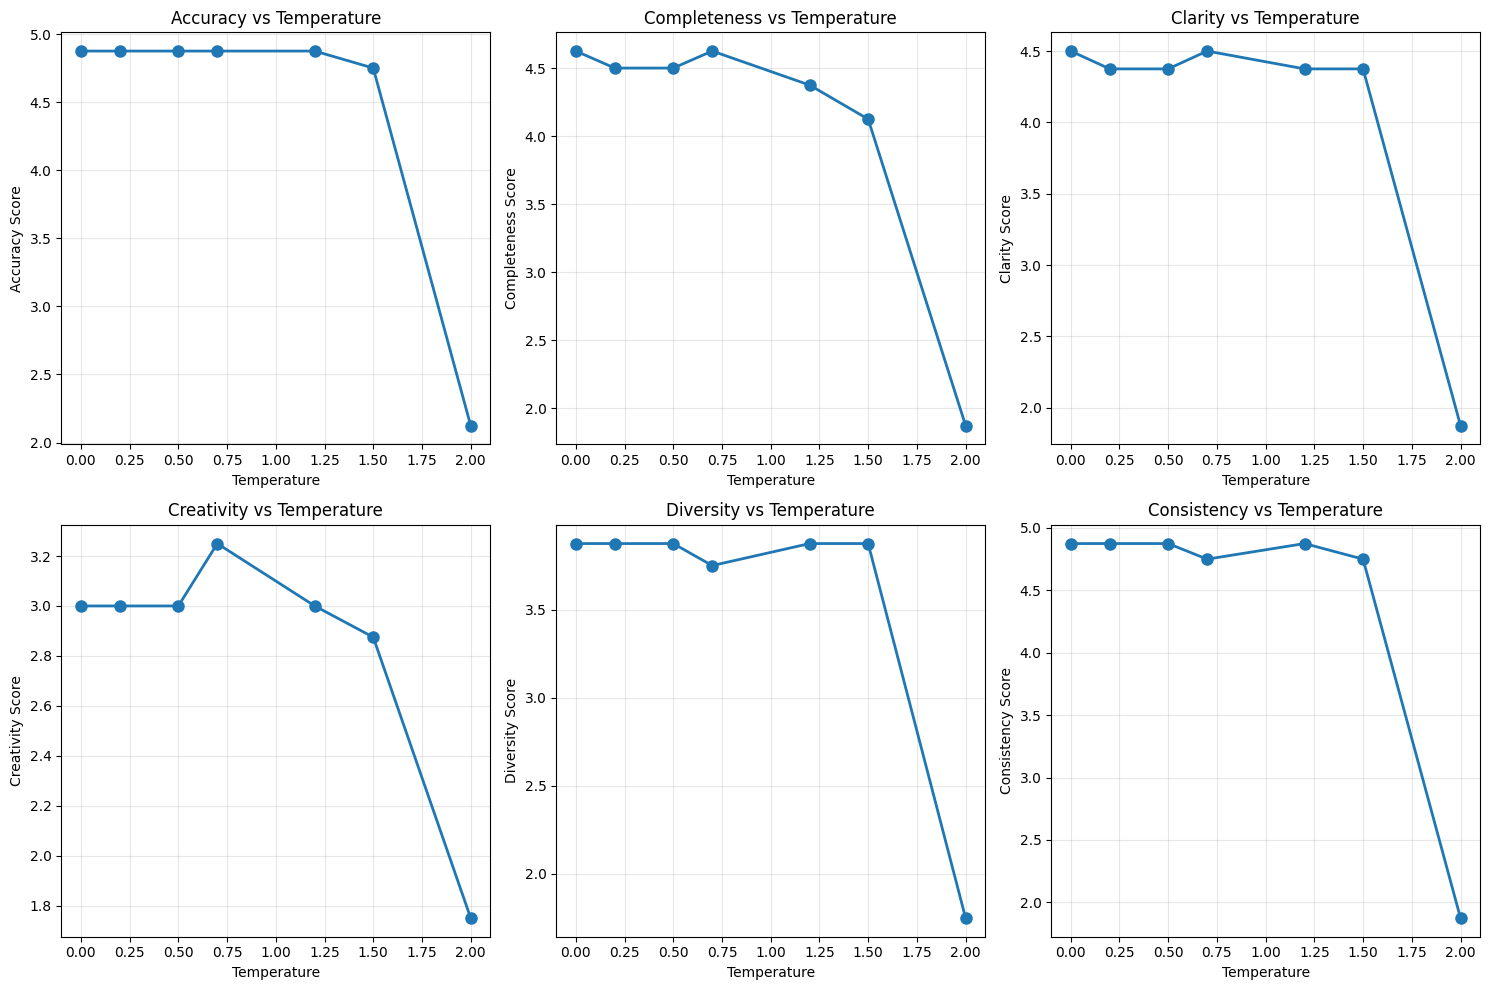

In [19]:
# Temperature vs Performance Line Plot
plt.figure(figsize=(15, 10))

temp_means = df.groupby('temperature')[metrics].mean()

for i, (metric, title) in enumerate(zip(metrics, titles)):
    plt.subplot(2, 3, i+1)
    plt.plot(temp_means.index, temp_means[metric], 'o-', linewidth=2, markersize=8)
    plt.title(f'{title} vs Temperature')
    plt.xlabel('Temperature')
    plt.ylabel(f'{title} Score')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



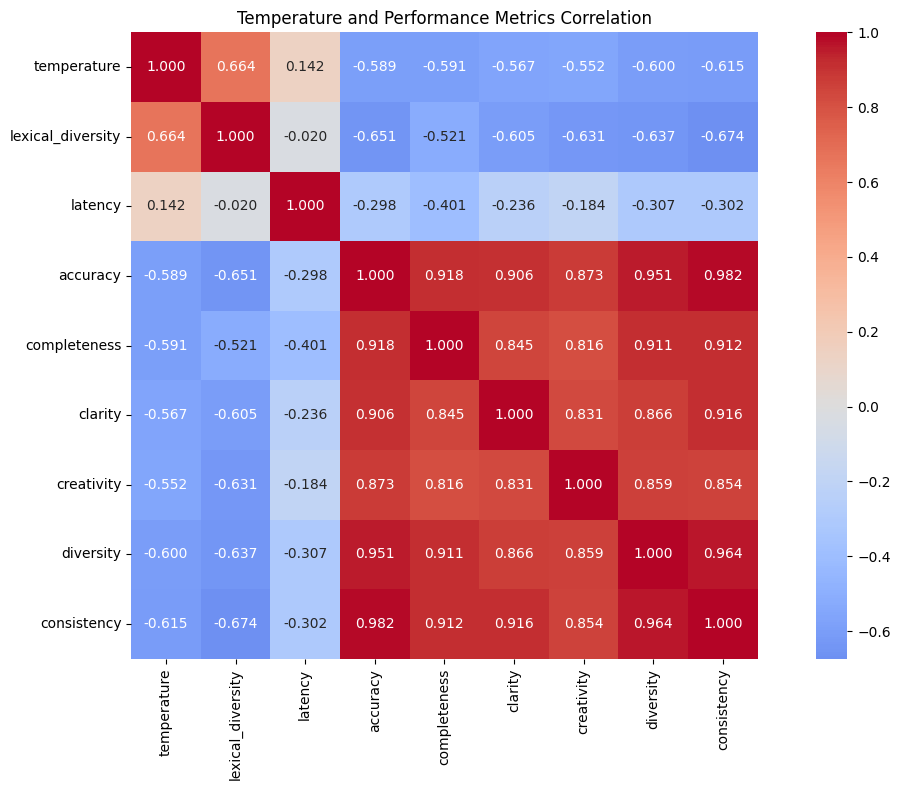

In [20]:
# Correlation Analysis
plt.figure(figsize=(12, 8))

corr_cols = ['temperature', 'lexical_diversity', 'latency'] + metrics
correlation_matrix = df[corr_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Temperature and Performance Metrics Correlation')
plt.tight_layout()
plt.show()

In [22]:
# Best Temperature Analysis
print("=== TEMPERATURE COMPARISON ANALYSIS ===")

# Overall performance by temperature
overall_performance = df.groupby('temperature')['overall_rating'].agg(['mean', 'std', 'count'])
overall_performance.columns = ['Mean_Score', 'Std_Dev', 'Count']
overall_performance = overall_performance.sort_values('Mean_Score', ascending=False)
print("\nOverall Performance by Temperature:")
print(overall_performance)

=== TEMPERATURE COMPARISON ANALYSIS ===

Overall Performance by Temperature:
             Mean_Score   Std_Dev  Count
temperature                             
0.7              4.4375  0.623212      8
0.0              4.3750  0.744024      8
0.2              4.3125  0.593867      8
0.5              4.1875  0.530330      8
1.2              4.1875  0.530330      8
1.5              4.1250  0.640870      8
2.0              1.7500  1.164965      8
